In [4]:
# Imports here
import torch
import PIL
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision import datasets, transforms, models
from torch import nn
from torch import optim
from collections import OrderedDict
from time import time
import copy
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
import skimage.io as io
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
data_dir = '/kaggle/input/eurosat-dataset'
train_dir = data_dir + '/EuroSAT'

# Define your transformations
train_transforms = transforms.Compose([
    #transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load all the images from the train folder
all_data = datasets.ImageFolder(train_dir, transform=train_transforms)

# Calculate the sizes for train, validation, and test sets
total_size = len(all_data)
train_size = int(0.7 * total_size)
test_size = int(0.2 * total_size)
valid_size = total_size - train_size - test_size

# Use random_split to split the dataset
train_data, valid_data, test_data = torch.utils.data.random_split(all_data, [train_size, valid_size, test_size])

# Create data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=False)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=50)
testloader = torch.utils.data.DataLoader(test_data, batch_size=50)

In [15]:
# Load a pre-trained network 
model = models.vgg13(pretrained=True)
model.name = "vgg19"
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): 

In [16]:
for param in model.parameters():
    param.requires_grad = False

In [17]:
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 10, bias=True)),
                          #('relu1', nn.ReLU()),
#                          ('dropout1', nn.Dropout(p=0.5)),
                          #('fc2', nn.Linear(4096, 10, bias=True)),
#                           ('relu2', nn.ReLU()),
#                           ('dropout2', nn.Dropout(p=0.5)),
#                           ('fc3', nn.Linear(512, 256, bias=True)),
#                           ('relu3', nn.ReLU()),
#                           ('dropout3', nn.Dropout(p=0.5)),
#                           ('fc4',nn.Linear(256,10,bias=True)),
                          ('output', nn.Softmax(dim=1))
                          ]))
    
model.classifier = classifier

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [20]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

epochs = 4
print_every = 30 # Prints every 30 images out of batch of 50 images
steps = 0

In [22]:
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    
    for ii, (inputs, labels) in enumerate(testloader):
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        output = model.forward(inputs)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [23]:
def train(model,steps,print_every,epochs):
    print("Training process initializing .....\n")

    for e in range(epochs):
        running_loss = 0
        model.train() 
    
        for ii, (inputs, labels) in enumerate(trainloader):
            steps += 1
        
            inputs, labels = inputs.to(device), labels.to(device)
        
            optimizer.zero_grad()
        
            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
        
            if steps % print_every == 0:
                model.eval()

                with torch.no_grad():
                    valid_loss, accuracy = validation(model, validloader, criterion)
            
                print("Epoch: {}/{} | ".format(e+1, epochs),
                      "Training Loss: {:.4f} | ".format(running_loss/print_every),
                      "Validation Loss: {:.4f} | ".format(valid_loss/len(validloader)),
                      "Validation Accuracy: {:.4f}".format(accuracy/len(validloader)))
            
                running_loss = 0
                model.train()

    print("\nTraining process is now complete!!")
    return model

In [26]:
model = train(model,steps,print_every,epochs)

Training process initializing .....

Epoch: 1/4 |  Training Loss: 1.5793 |  Validation Loss: 1.5850 |  Validation Accuracy: 0.8748
Epoch: 1/4 |  Training Loss: 1.5794 |  Validation Loss: 1.5742 |  Validation Accuracy: 0.8889
Epoch: 1/4 |  Training Loss: 1.5658 |  Validation Loss: 1.5977 |  Validation Accuracy: 0.8637
Epoch: 1/4 |  Training Loss: 1.5815 |  Validation Loss: 1.5681 |  Validation Accuracy: 0.8948
Epoch: 1/4 |  Training Loss: 1.5886 |  Validation Loss: 1.5814 |  Validation Accuracy: 0.8811
Epoch: 1/4 |  Training Loss: 1.5882 |  Validation Loss: 1.5923 |  Validation Accuracy: 0.8700
Epoch: 1/4 |  Training Loss: 1.5992 |  Validation Loss: 1.5914 |  Validation Accuracy: 0.8719
Epoch: 1/4 |  Training Loss: 1.5996 |  Validation Loss: 1.5795 |  Validation Accuracy: 0.8830
Epoch: 1/4 |  Training Loss: 1.5746 |  Validation Loss: 1.5959 |  Validation Accuracy: 0.8663
Epoch: 1/4 |  Training Loss: 1.5839 |  Validation Loss: 1.5911 |  Validation Accuracy: 0.8719
Epoch: 1/4 |  Training 

In [28]:
def pred(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [29]:
labels_fp32,predictions_fp32 = pred(model,testloader)

Time:  62.06348490715027
Accuracy achieved by the network on test images is: 86%


In [30]:
import seaborn as sns
def metrics(labels,predictions):
    classes = train_data.dataset.classes
    cm = confusion_matrix(np.array(labels), np.array(predictions))
    print("Confusion Matrix:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    print('----------------------------------------------------------------')
    print("Classification Report:")
    report = classification_report(np.array(labels),np.array(predictions))
    print(report)

Confusion Matrix:


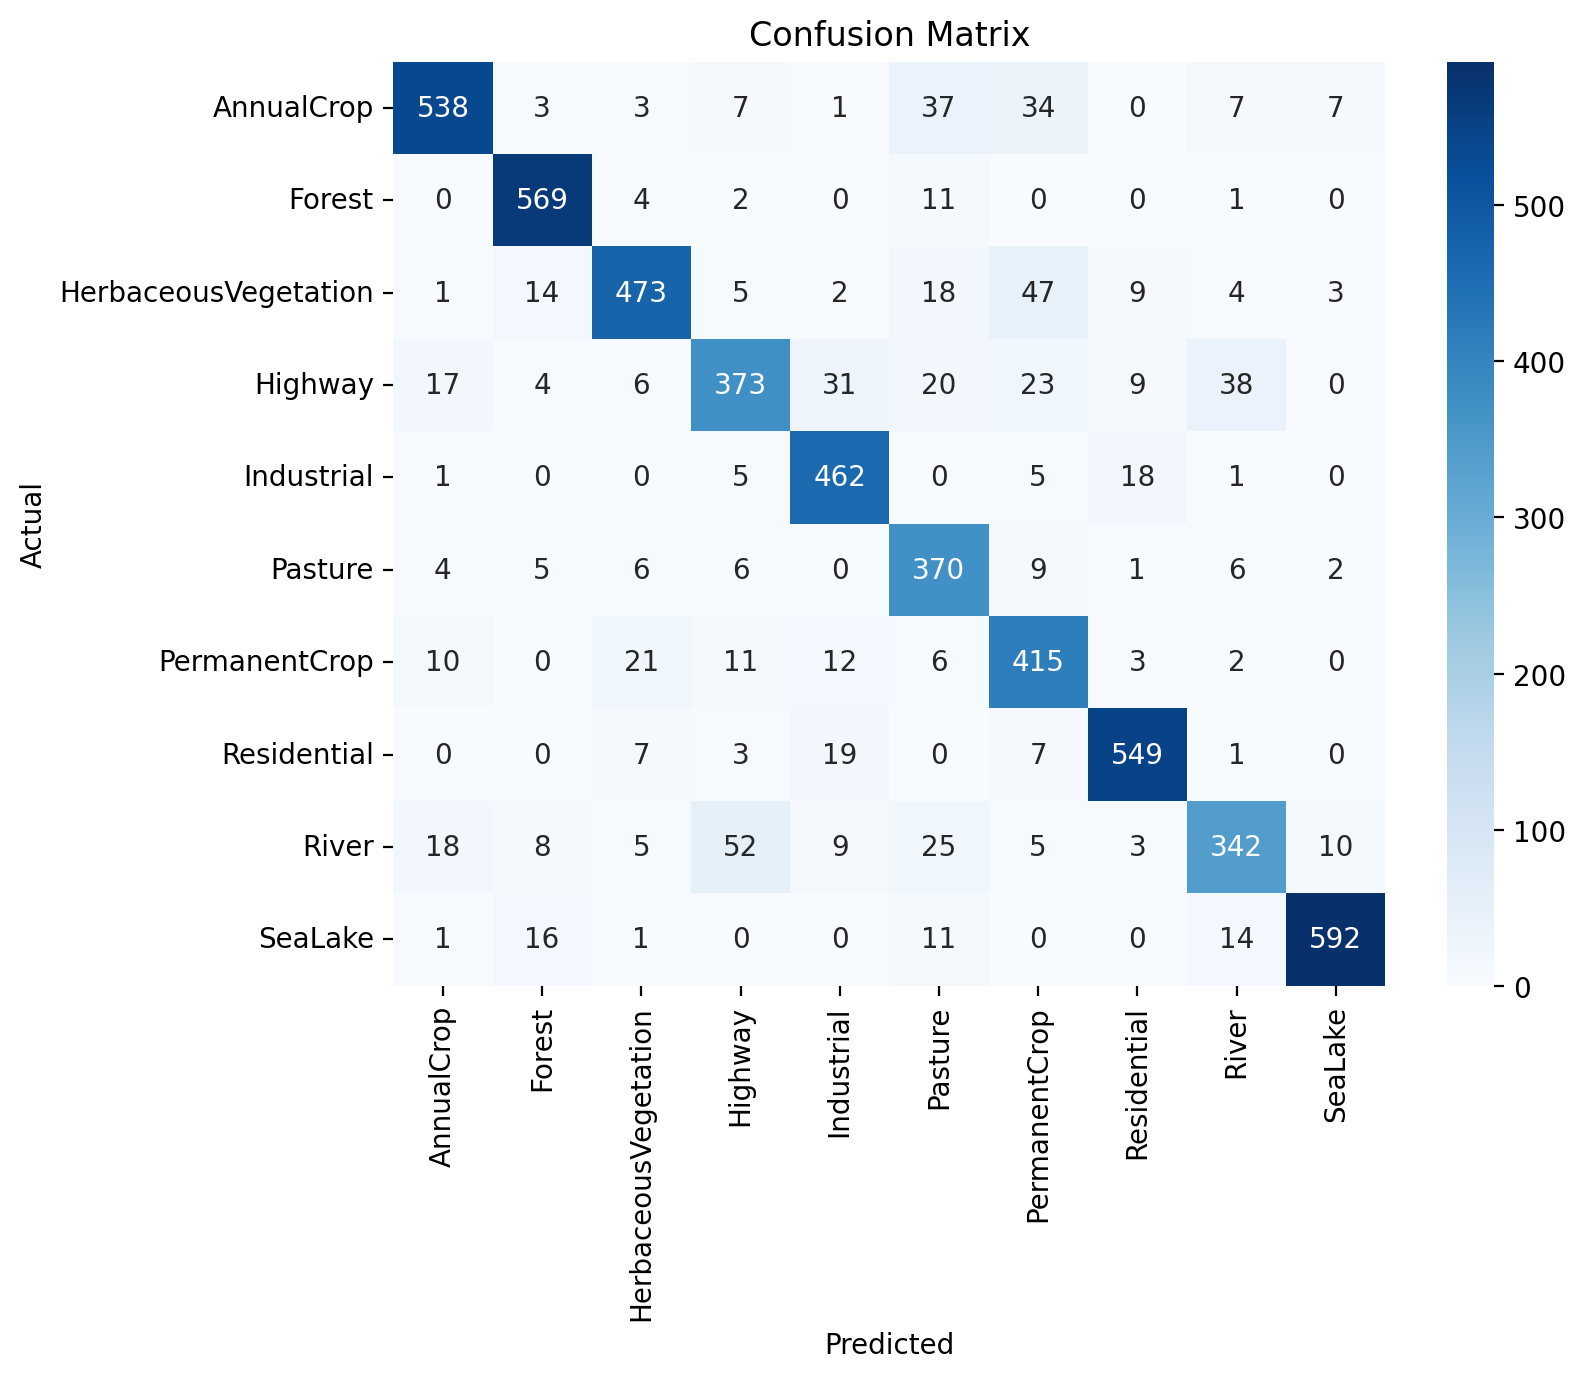

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.88       637
           1       0.92      0.97      0.94       587
           2       0.90      0.82      0.86       576
           3       0.80      0.72      0.76       521
           4       0.86      0.94      0.90       492
           5       0.74      0.90      0.82       409
           6       0.76      0.86      0.81       480
           7       0.93      0.94      0.93       586
           8       0.82      0.72      0.77       477
           9       0.96      0.93      0.95       635

    accuracy                           0.87      5400
   macro avg       0.86      0.86      0.86      5400
weighted avg       0.87      0.87      0.87      5400



In [31]:
metrics(labels_fp32,predictions_fp32)

In [18]:
import os
def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
    os.remove('tmp.pt')

In [19]:
print("Size of fp32 model:",end='')
print_model_size(model)

Size of fp32 model:38.63 MB


# Quantization

# FP-16

In [34]:
model_fp16 = copy.deepcopy(model)

In [35]:
model_fp16.half()
model_fp16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [36]:
def pred_fp16(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images.half())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [37]:
labels_fp16,predictions_fp16 = pred_fp16(model_fp16,testloader)

Time:  30.61916208267212
Accuracy achieved by the network on test images is: 86%


Confusion Matrix:


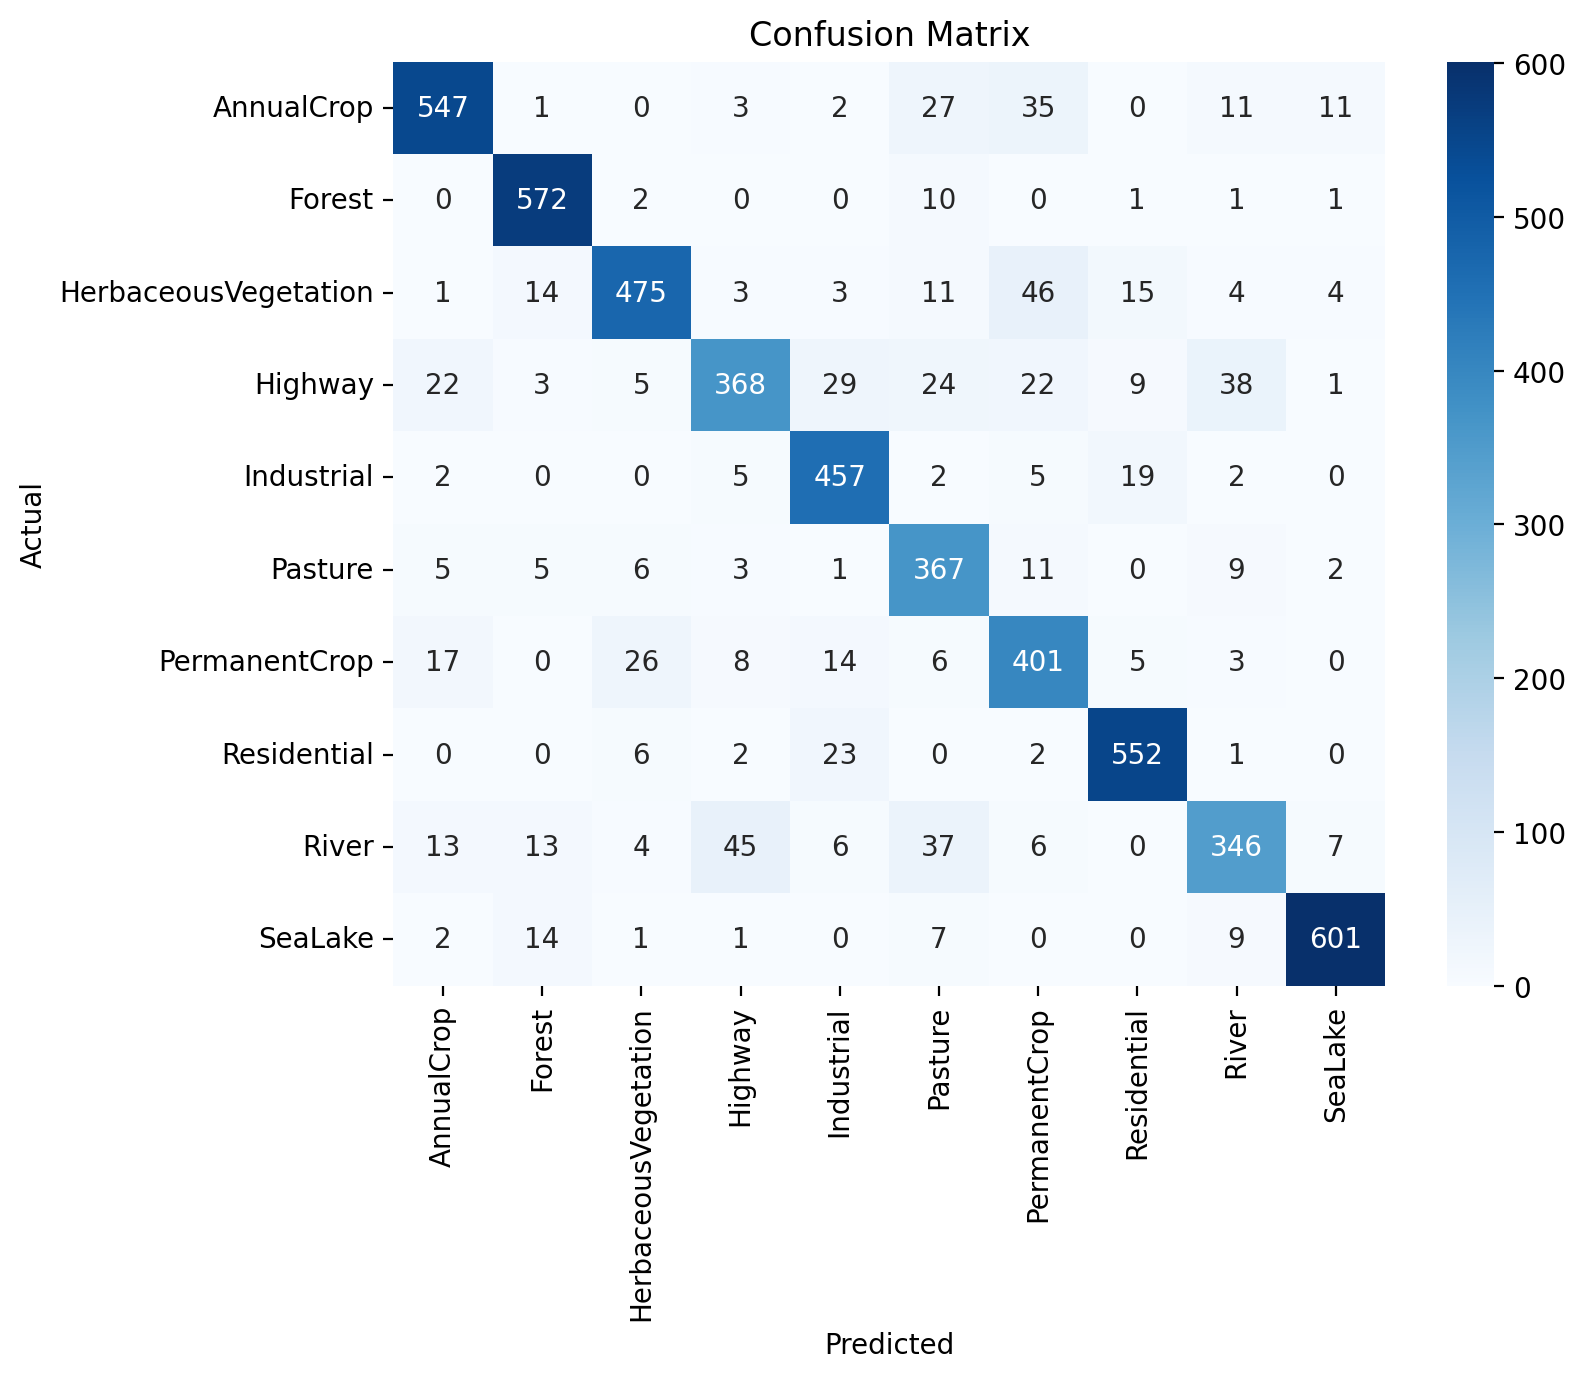

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       637
           1       0.92      0.97      0.95       587
           2       0.90      0.82      0.86       576
           3       0.84      0.71      0.77       521
           4       0.85      0.93      0.89       492
           5       0.75      0.90      0.82       409
           6       0.76      0.84      0.80       480
           7       0.92      0.94      0.93       586
           8       0.82      0.73      0.77       477
           9       0.96      0.95      0.95       635

    accuracy                           0.87      5400
   macro avg       0.86      0.86      0.86      5400
weighted avg       0.87      0.87      0.87      5400



In [38]:
metrics(labels_fp16,predictions_fp16)

# FP-64

In [39]:
model_64 = copy.deepcopy(model)
model_64.double()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [40]:
model_64.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [41]:
def pred_fp64(Model,Testloader):
    all_labels = []
    all_predictions = []
    correct = 0
    total = 0
    start_time = time()
    with torch.no_grad():
        Model.eval()
        for images, labels in Testloader:
            all_labels.extend(labels.numpy())
            images, labels = images.to(device), labels.to(device)
            outputs = Model(images.double())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_tensor_cpu = predicted.to('cpu')
            all_predictions.extend(predicted_tensor_cpu.numpy())
    end_time = time()
    print("Time: ",end_time - start_time)
    print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct / total))
    
    return all_labels,all_predictions

In [42]:
 labels,predictions = pred_fp64(model_64,testloader)

Time:  1628.3403532505035
Accuracy achieved by the network on test images is: 87%


## INT-8

In [43]:
import torch
from torch.ao.quantization import (
  get_default_qconfig_mapping,
  get_default_qat_qconfig_mapping,
  QConfigMapping,
)
import torch.ao.quantization.quantize_fx as quantize_fx

### PTQ

In [44]:
model.to('cpu')

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [45]:
input_data = next(iter(trainloader))[0] 
calibrate_data = input_data.to("cpu")

In [46]:
model_int8 = copy.deepcopy(model)

qconfig_mapping = get_default_qconfig_mapping("x86")
model_int8.eval()
# prepare
model_prepared = quantize_fx.prepare_fx(model_int8, qconfig_mapping, calibrate_data)
# calibrate

/opt/conda/lib/python3.10/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/opt/conda/lib/python3.10/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/opt/conda/lib/python3.10/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/opt/conda/lib/python3.10/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [47]:
with torch.no_grad():
    for i in range(20):
        batch = next(iter(trainloader))[0]
        output = model_prepared(batch.to('cpu'))

In [48]:
model_quantized_static = quantize_fx.convert_fx(model_prepared)
model_quantized_static.state_dict()

OrderedDict([('features_0_input_scale_0', tensor(0.0348)),
             ('features_0_input_zero_point_0', tensor(51)),
             ('features.0.weight',
              tensor([[[[-0.0534, -0.0499, -0.0677],
                        [ 0.0160,  0.0445,  0.0018],
                        [ 0.0356,  0.0196,  0.0196]],
              
                       [[ 0.0178,  0.0552, -0.0053],
                        [ 0.1425,  0.2262,  0.1371],
                        [ 0.1193,  0.1994,  0.0926]],
              
                       [[-0.0445,  0.0125, -0.0142],
                        [ 0.0605,  0.1389,  0.0534],
                        [-0.0018,  0.0588, -0.0303]]],
              
              
                      [[[ 0.2627, -0.3042, -0.5024],
                        [ 0.4149, -0.2074, -0.4886],
                        [ 0.5854,  0.4287, -0.1383]],
              
                       [[ 0.2858, -0.3319, -0.4563],
                        [ 0.3780, -0.2904, -0.4978],
                        

In [49]:
model_quantized_static

GraphModule(
  (features): Module(
    (0): QuantizedConvReLU2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.04454943910241127, zero_point=0, padding=(1, 1))
    (2): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.06679628789424896, zero_point=0, padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.0669218972325325, zero_point=0, padding=(1, 1))
    (7): QuantizedConvReLU2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.11530311405658722, zero_point=0, padding=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): QuantizedConvReLU2d(128, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.14282727241516113, zero_point=0, padding=(1, 1))
    (12): QuantizedConvReLU2d(256, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.13145413994789124, zero_point=0, padding=(1, 1))
    (14): Quanti

In [50]:
model_quantized_static.to('cpu')

GraphModule(
  (features): Module(
    (0): QuantizedConvReLU2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.04454943910241127, zero_point=0, padding=(1, 1))
    (2): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.06679628789424896, zero_point=0, padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.0669218972325325, zero_point=0, padding=(1, 1))
    (7): QuantizedConvReLU2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.11530311405658722, zero_point=0, padding=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): QuantizedConvReLU2d(128, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.14282727241516113, zero_point=0, padding=(1, 1))
    (12): QuantizedConvReLU2d(256, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.13145413994789124, zero_point=0, padding=(1, 1))
    (14): Quanti

In [51]:
all_predictions_int8 = []
all_labels_int8 = []
correct_pred = 0
total_pred = 0
start_time_int8 = time()
with torch.no_grad():
    model_quantized_static.eval()
    for data in testloader:
        images, labels = data
        all_labels_int8.extend(labels.numpy())
        #images, labels = images.to(device), labels.to(device)
        outputs = model_quantized_static(images.to('cpu'))
        _, predicted = torch.max(outputs.data, 1)
        total_pred += labels.size(0)
        correct_pred += (predicted == labels).sum().item()
        predicted_tensor_cpu = predicted.to('cpu')
        all_predictions_int8.extend(predicted_tensor_cpu.numpy())
end_time_int8 = time()
print("Time: ",end_time_int8 - start_time_int8)
print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct_pred / total_pred))

Time:  785.3176536560059
Accuracy achieved by the network on test images is: 83%


Confusion Matrix:


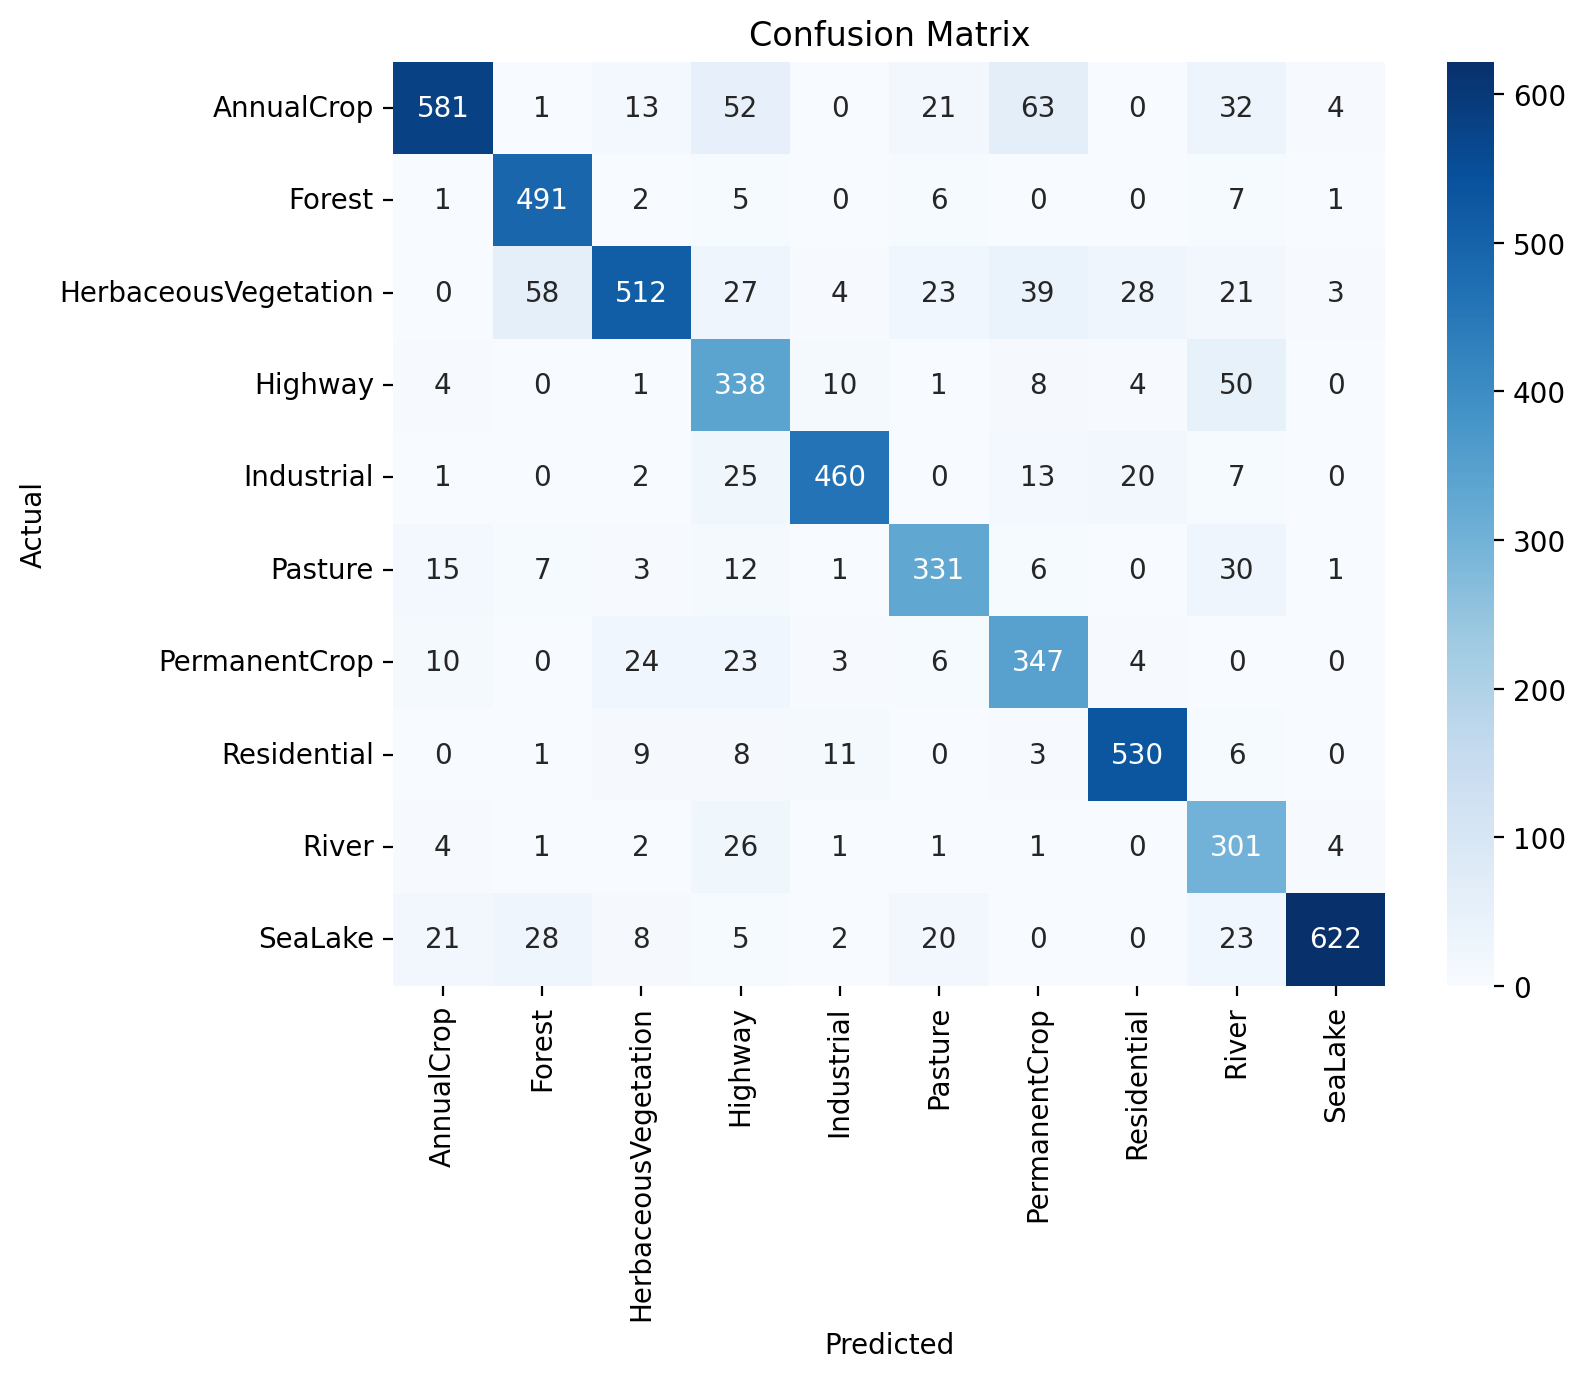

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.76      0.83       767
           1       0.84      0.96      0.89       513
           2       0.89      0.72      0.79       715
           3       0.65      0.81      0.72       416
           4       0.93      0.87      0.90       528
           5       0.81      0.82      0.81       406
           6       0.72      0.83      0.77       417
           7       0.90      0.93      0.92       568
           8       0.63      0.88      0.74       341
           9       0.98      0.85      0.91       729

    accuracy                           0.84      5400
   macro avg       0.83      0.84      0.83      5400
weighted avg       0.85      0.84      0.84      5400



In [52]:
metrics(all_predictions_int8,all_labels_int8)

### QAT

Load a new vgg model which is not trained before starting qat

In [53]:
input_data = next(iter(trainloader))[0]
calibrate_data = input_data.to(device)

In [54]:
model.eval()
model.qconfig = torch.ao.quantization.get_default_qat_qconfig('x86')
model.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [55]:
qconfig_mapping = get_default_qat_qconfig_mapping("x86")
model_prepared = quantize_fx.prepare_qat_fx(model, qconfig_mapping, calibrate_data)

/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [56]:
model_prepared.to(device)

GraphModule(
  (activation_post_process_0): FusedMovingAvgObsFakeQuantize(
    fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
    (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
  )
  (features): Module(
    (0): ConvReLU2d(
      3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
        fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
        (activation_post_process): MovingAveragePerChannelMinMaxObse

In [57]:
model_prepared = train(model_prepared,steps,print_every,epochs)

Training process initializing .....



/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/fake_quantize.py:343: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/ReduceAllOps.cpp:72.)
  return torch.fused_moving_avg_obs_fake_quant(
/opt/conda/lib/python3.10/site-packages/torch/ao/quantization/fake_quantize.py:343: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorCompare.cpp:677.)
  return torch.fused_moving_avg_obs_fake_quant(


Epoch: 1/4 |  Training Loss: 1.6093 |  Validation Loss: 1.6014 |  Validation Accuracy: 0.8630
Epoch: 1/4 |  Training Loss: 1.5888 |  Validation Loss: 1.5954 |  Validation Accuracy: 0.8681
Epoch: 1/4 |  Training Loss: 1.5879 |  Validation Loss: 1.5867 |  Validation Accuracy: 0.8770
Epoch: 1/4 |  Training Loss: 1.5871 |  Validation Loss: 1.5922 |  Validation Accuracy: 0.8715
Epoch: 1/4 |  Training Loss: 1.5939 |  Validation Loss: 1.6011 |  Validation Accuracy: 0.8637
Epoch: 1/4 |  Training Loss: 1.5902 |  Validation Loss: 1.5959 |  Validation Accuracy: 0.8689
Epoch: 1/4 |  Training Loss: 1.6010 |  Validation Loss: 1.5879 |  Validation Accuracy: 0.8774
Epoch: 1/4 |  Training Loss: 1.6025 |  Validation Loss: 1.5884 |  Validation Accuracy: 0.8767
Epoch: 1/4 |  Training Loss: 1.5871 |  Validation Loss: 1.5902 |  Validation Accuracy: 0.8741
Epoch: 1/4 |  Training Loss: 1.6086 |  Validation Loss: 1.5900 |  Validation Accuracy: 0.8711
Epoch: 1/4 |  Training Loss: 1.5946 |  Validation Loss: 1.57

In [58]:
model_prepared.to('cpu')

GraphModule(
  (activation_post_process_0): FusedMovingAvgObsFakeQuantize(
    fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([0.0347]), zero_point=tensor([51], dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
    (activation_post_process): MovingAverageMinMaxObserver(min_val=-1.7691107988357544, max_val=2.6399881839752197)
  )
  (features): Module(
    (0): ConvReLU2d(
      3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
        fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([0.0018, 0.0046, 0.0030, 0.0037, 0.0026, 0.0026, 0.0056, 0.0025, 0.0040,
                0.0016, 0.0039, 0.0067, 0.0045, 0.0042, 0.0025, 0.0048, 0.0064, 0.0033,
                0.0046, 0.0056, 0.0072, 0.0080, 0.0034, 0.0027, 0.0034, 0.0029, 0.0033,
                0.0049, 0.0067, 0.0090, 0.0085, 0.0054, 0.0078, 0.0071, 0.00

In [59]:
model_quantized_trained = quantize_fx.convert_fx(model_prepared)

In [60]:
model_quantized_trained.to('cpu')

GraphModule(
  (features): Module(
    (0): QuantizedConvReLU2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.08160386979579926, zero_point=0, padding=(1, 1))
    (2): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.0844205692410469, zero_point=0, padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.12305499613285065, zero_point=0, padding=(1, 1))
    (7): QuantizedConvReLU2d(128, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.1892154961824417, zero_point=0, padding=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): QuantizedConvReLU2d(128, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.27890658378601074, zero_point=0, padding=(1, 1))
    (12): QuantizedConvReLU2d(256, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.2662111520767212, zero_point=0, padding=(1, 1))
    (14): Quantize

In [61]:
all_predictions_int8 = []
all_labels_int8 = []
correct_pred = 0
total_pred = 0
start_time_int8 = time()
with torch.no_grad():
    model_quantized_trained.eval()
    for data in testloader:
        images, labels = data
        all_labels_int8.extend(labels.numpy())
        #images, labels = images.to(device), labels.to(device)
        outputs = model_quantized_trained(images.to('cpu'))
        _, predicted = torch.max(outputs.data, 1)
        total_pred += labels.size(0)
        correct_pred += (predicted == labels).sum().item()
        predicted_tensor_cpu = predicted.to('cpu')
        all_predictions_int8.extend(predicted_tensor_cpu.numpy())
end_time_int8 = time()
print("Time: ",end_time_int8 - start_time_int8)
print('Accuracy achieved by the network on test images is: %d%%' % (100 * correct_pred / total_pred))

Time:  770.1683151721954
Accuracy achieved by the network on test images is: 86%


Confusion Matrix:


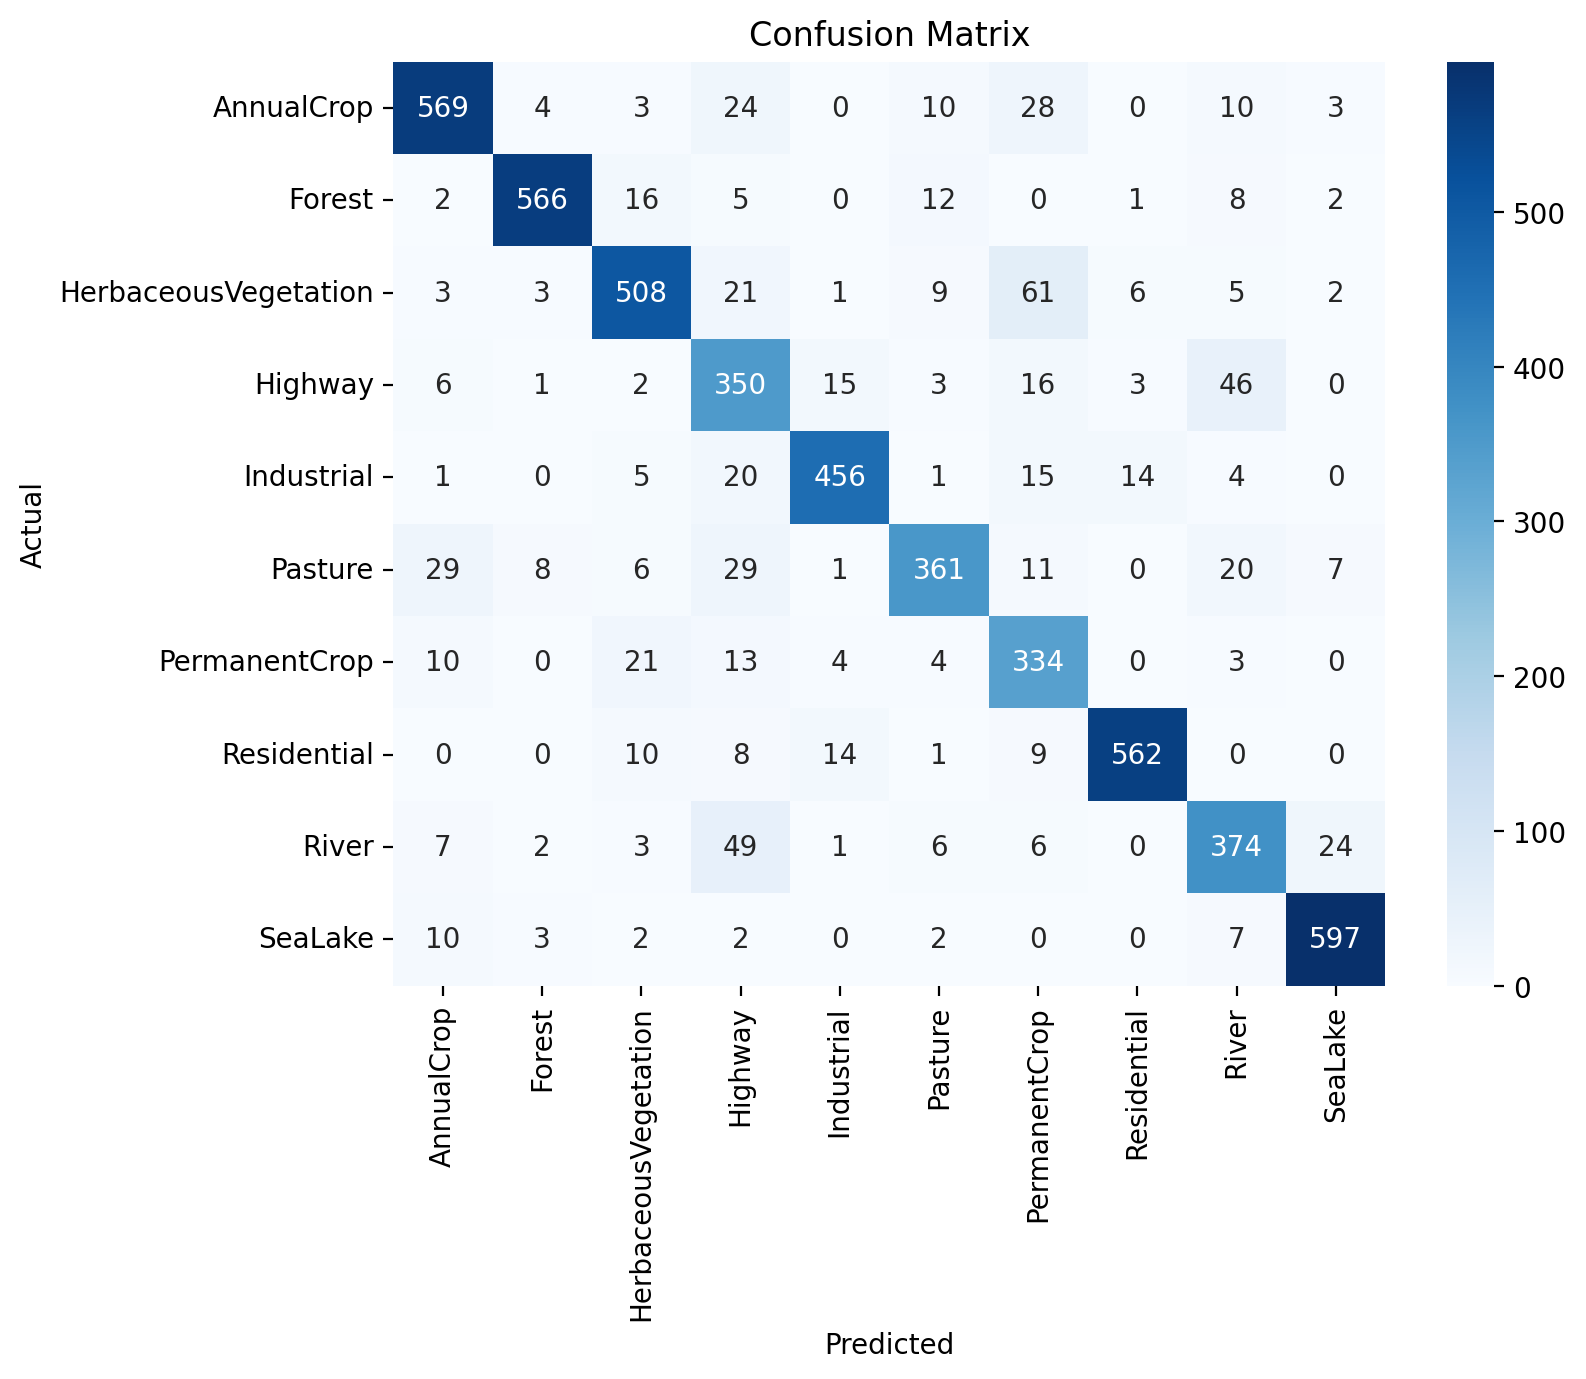

----------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       651
           1       0.96      0.92      0.94       612
           2       0.88      0.82      0.85       619
           3       0.67      0.79      0.73       442
           4       0.93      0.88      0.90       516
           5       0.88      0.76      0.82       472
           6       0.70      0.86      0.77       389
           7       0.96      0.93      0.94       604
           8       0.78      0.79      0.79       472
           9       0.94      0.96      0.95       623

    accuracy                           0.87      5400
   macro avg       0.86      0.86      0.86      5400
weighted avg       0.87      0.87      0.87      5400



In [62]:
metrics(all_predictions_int8,all_labels_int8)

In [63]:
print("Size of fp16 model:",end='')
print_model_size(model_fp16)
print("Size of PTQ model:",end='')
print_model_size(model_quantized_static)
print("Size of QAT model:",end='')
print_model_size(model_quantized_trained)

Size of fp16 model:40.56 MB
Size of PTQ model:20.41 MB
Size of QAT model:20.41 MB
